### Instituto Tecnologico de Costa Rica (ITCR)
### Sede Interuniversitaria de Alajuela
### Escuela de Computacion
### Curso: Inteligencia Artificial
### Estudiantes: 

 - Brandon Ledezma Fernández - 2018185574
 - Walter Morales Vásquez - 2018212846

### Profesora:
 
 - Maria Auxiliadora Mora


# Tarea Programada Número 4
---
#### Introducción:
En este trabajo práctico se aplicarán conceptos básicos de aprendizaje automático
utilizando redes neuronales recurrentes para resolver problemas que involucran el
procesamiento de lenguaje natural.

El o los estudiantes deberán realizar dos ejercicios. El primero consiste en implementar
una red neuronal recurrente aplicada a un problema de clasificación de textos de opinión
sobre prendas de vestir de mujer. El segundo ejercicio consiste en reconocer nombres de
entidades en textos (NER, Named-Entity Recognition)

El objetivo del trabajo es poner en práctica las habilidades de investigación y el
conocimiento adquirido durante el curso sobre redes neuronales por medio de
ejercicios prácticos que permitan al estudiante experimentar con el aprendizaje profundo. 

In [174]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split

from ner_evaluation.ner_eval import Evaluator
from ner_evaluation.ner_eval import collect_named_entities
from ner_evaluation.ner_eval import compute_metrics
from ner_evaluation.ner_eval import compute_precision_recall_wrapper

import matplotlib.pyplot as plt

## A. Clasificación   de   textos   con   redes   neuronales   recurrentes  LSTM utilizando Pytorch.

Se desea que, dado un comentario de revisión de una prenda de vestir, predecir la calificación dada por el comprador. La calificación toma valores enteros entre 1 y 5, donde 1 corresponde a la peor calificación y 5 a la mejor.

Datos: Utilice los datos de evaluación de prendas de vestir de mujer disponibles en Kaggle (nicapotato, 2018) para:

1. Cargue y prepare los datos para ser introducidos a la red LSTM.

In [189]:
#nRowsRead = 1000

# Se carga el archivo con los datos solicitados (defaultofcredit.csv) y se define
# a la columna "default_payment_next_month" como la objetivo.
reviews = pd.read_csv('./data/Womens Clothing E-Commerce Reviews.csv', delimiter=',')#, nrows=nRowsRead)
#reviews = pd.read_csv('./data/a.csv')
reviews.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


In [190]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and "}

def cont_to_exp(x):
    if type(x) is str:
        x = x.replace('\\', '')
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x
    
reviews['Review Text'] = reviews['Review Text'].apply(lambda x: cont_to_exp(x))

In [192]:
# Delete missing observations for following variables
# for x in ["Clothing ID","Age","Title","Review Text","Rating","Recommended IND","Positive Feedback Count","Division Name","Department Name","Class Name"]:
#     reviews = reviews[reviews[x].notnull()]
    
# X = reviews.drop(columns = reviews.columns[3:5])
# X = pd.get_dummies(X)
# y = reviews['Review Text']
# y = [elem.split() for elem in y]

#reviews['Rating'] = reviews[(reviews['Rating'] >= 1)  (reviews['Rating'] <= 5)]

reviews = reviews[reviews["Review Text"].notnull()]
reviews = reviews[reviews["Rating"].notnull()]

from string import punctuation

def preprocesar_texto(texto):
    
    texto = texto.lower()
    texto = "".join([ch if ch not in punctuation else " " for ch in texto])
#     texto = "".join([ch for ch in texto if ch not in punctuation])
    return texto

# reviews['Review Text'] = reviews['Review Text'].apply(lambda x: preprocesar_texto(x))

X = reviews['Review Text']#.tolist()
X = X.tolist()

for i in range(len(X)):
    X[i] = preprocesar_texto(X[i])

#print(X)

X = [elem.split() for elem in X]

# for i in range(len(X)):
#     temp = []
#     for j in range(len(X[i])):
#         temp.append(preprocesar_texto(X[i][j]))
#     X[i] = temp

y = reviews['Rating']#.tolist()

print(1, y.tolist().count(1))
print(2, y.tolist().count(2))
print(3, y.tolist().count(3))
print(4, y.tolist().count(4))
print(5, y.tolist().count(5))

word_to_ix = {"":0}

for review in X:
#     print(review)
#     if review not in word_to_ix:
#         word_to_ix[review] = len(word_to_ix)
    for word in review:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

ratings = [1, 2, 3, 4, 5]

1 821
2 1549
3 2823
4 4908
5 12540


In [178]:
max_lenght = 0
for elem in X:
    if max_lenght < len(elem):
        max_lenght = len(elem)

        
# for i in range(len(X)):
#     largo = len(X[i])
#     if largo < max_lenght:
#         X[i] += ['<pad>']*(max_lenght-largo)
# print(unique)

print(max_lenght)

palabras_diferentes = set([elem for row in X for elem in row])
cantidad_palabras = len(palabras_diferentes)

print(cantidad_palabras)

#print(palabras_diferentes)
# palabras_diferentes
# np.savetxt('output.txt', arreglo, delimiter=',')
# X
# palabras_diferentes
# Preparación de los datos 
def prepare_sequence(seq, to_ix):
    # Prepara tensores de indices de palabras a partir de una oración.
    # Parámetros:
    #   seq: oración
    #   to_ix: diccionario de palabras.
#     print(seq)
    idxs = [to_ix[w] for w in seq]
    #idxs = to_ix[seq]
    return idxs

X_procesada = []
for i in range(len(X)):
    temp = prepare_sequence(X[i], word_to_ix)
    X_procesada.append([temp, len(temp)])
    
print(X_procesada[:5])
    
# def padding_(sentences, seq_len):
#     features = np.zeros((len(sentences), seq_len),dtype=int)
#     for ii, review in enumerate(sentences):
#         if len(review) != 0:
#             features[ii, -len(review):] = np.array(review)[:seq_len]
#     return features

118
14168
[[[1, 2, 3, 4, 5, 4, 6], 7], [[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 10, 18, 19, 20, 4, 14, 21, 22, 14, 23, 24, 14, 25, 26, 27, 28, 10, 29, 24, 10, 11, 30, 14, 31, 19, 30, 4, 21, 32, 33, 14, 7, 34, 35, 36, 37, 38, 39, 19, 40, 41, 34, 42, 26, 43, 44, 19, 45, 46, 36, 47, 48, 11, 49, 30], 66], [[14, 50, 51, 52, 53, 54, 8, 9, 4, 55, 56, 10, 16, 57, 54, 37, 14, 58, 28, 34, 30, 59, 60, 61, 62, 63, 14, 64, 8, 16, 44, 65, 59, 66, 59, 18, 67, 68, 14, 69, 70, 71, 10, 72, 14, 73, 10, 18, 30, 74, 75, 76, 39, 77, 78, 34, 79, 80, 76, 6, 4, 81, 82, 63, 34, 83, 80, 50, 19, 84, 85, 86, 87, 4, 88, 89, 90, 91, 92, 93, 94, 19, 95, 96, 97, 76, 34, 91, 92, 87, 98, 99, 100, 34, 101, 10, 102], 97], [[14, 7, 7, 7, 8, 103, 10, 11, 104, 105, 4, 106, 107, 108, 14, 109, 10, 14, 110, 111, 63, 112, 113], 23], [[8, 114, 11, 84, 115, 16, 116, 117, 16, 34, 118, 119, 120, 10, 11, 34, 121, 35, 16, 109, 122, 123, 4, 10, 11, 124, 66, 10, 125, 126, 122, 127, 128, 7, 8, 114], 36]]


In [179]:
print(X_procesada[-1])

def padding_(sentences, seq_len):
    features = [[0]*seq_len for i in range(len(sentences))]#np.zeros((len(sentences), seq_len), dtype=int)
    for ii, review in enumerate(sentences):
        largo = review[1]
        if largo != 0:
            features[ii][:largo] = np.array(review[0])[:seq_len]
            features[ii] = [features[ii], largo]
#             features[ii] = np.concatenate((features[ii], [largo]), axis=0)# = features[ii] + [largo]
    return features

X_procesada = padding_(X_procesada, 70)# Promedio de largo #max_lenght)
print(X_procesada[1])

[[8, 9, 18, 19, 693, 14168, 11, 239, 4, 273, 261, 1172, 16, 109, 4, 583, 248, 1894, 747], 19]
[[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 10, 18, 19, 20, 4, 14, 21, 22, 14, 23, 24, 14, 25, 26, 27, 28, 10, 29, 24, 10, 11, 30, 14, 31, 19, 30, 4, 21, 32, 33, 14, 7, 34, 35, 36, 37, 38, 39, 19, 40, 41, 34, 42, 26, 43, 44, 19, 45, 46, 36, 47, 48, 11, 49, 30, 0, 0, 0, 0], 66]


In [180]:
print(max_lenght)

118


2. Utilizando PyTorch defina una red recurrente LSTM para procesar el conjunto de datos y clasificar los comentarios de usuario. 

In [181]:
def tensor_mean(input):
    
    #output = torch.tensor(np.zeros(input[0].size(0)))
    print('input', input)
    #input?
    output = input.clone().detach()
    #output.grad_fn.data.copy_(input.grad_fn.data)
    
    input = input[torch.arange(input.size(0))==0].double()
#     print('output', output)
#     print('input', input)
#     print('output', output)
#     print('output', output[0])
#     print('input[0].size(0)', input[0].size(0))
    
    for i in range(1, output.size(0)):
        for j in range(output[i].size(0)):
            input[0][j] += output[i][j]
            
    for i in range(input[0].size(0)):
        input[0][i] /= output.size(0)
    return input
    #return torch.tensor([output.tolist()], grad_fn=input.grad_fn)#requires_grad=False) grad_fn=input.grad

# Funciones utilitarias

def max_values(x):
    # Retorna el valor máximo y en índice o la posición del valor en un vector x.
    # Parámetros: 
    #    x: vector con los datos. 
    # Salida: 
    #    out: valor 
    #    inds: índice
    out, inds = torch.max(x,dim=1)   
    return out, inds

print(tensor_mean(torch.tensor([[1,1],[3,3]])))
#max_values(torch.tensor([[1,2,1,5,9]]))

def clone_vs_deepcopy(x):
    import copy
    import torch

    x_clone = x.clone()
    x_deep_copy = copy.deepcopy(x)
    #
    x.mul_(-1)
    print(f'x = {x}')
    print(f'x_clone = {x_clone}')
    print(f'x_deep_copy = {x_deep_copy}')

input tensor([[1, 1],
        [3, 3]])
tensor([[2., 2.]], dtype=torch.float64)


In [182]:

class LSTM(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

batch_size = 150# No es mucho?
vocab_size = len(word_to_ix)
EMBEDDING_DIM = 50
HIDDEN_DIM = 50
    
# Instancia del modelo
model = LSTM(vocab_size, EMBEDDING_DIM, HIDDEN_DIM) # len([1,2,3,4,5]))

# Función de pérdida: Negative Log Likelihood Loss (NLLL). 
# Útil para problemas de clasificacion con C clases.
# loss_function = F.cross_entropy(y_pred, y)#nn.NLLLoss()

# Optimizador Stochastic Gradient Descent  
optimizer = optim.Adam(model.parameters(), lr=0.1)#SGD(model.parameters(), lr=0.1)
    
# Definición del modelo

    

In [183]:
#     # Incialización del modelo
# #     def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
# #         super(LSTMTagger, self).__init__()
# #         self.hidden_dim = hidden_dim

# #         # Primero se pasa la entrada a través de una capa Embedding. 
# #         # Esta capa construye una representación de los tokens de 
# #         # un texto donde las palabras que tienen el mismo significado 
# #         # tienen una representación similar.
        
# #         # Esta capa captura mejor el contexto y son espacialmente 
# #         # más eficientes que las representaciones vectoriales (one-hot vector).
# #         # En Pytorch, se usa el módulo nn.Embedding para crear esta capa, 
# #         # que toma el tamaño del vocabulario y la longitud deseada del vector 
# #         # de palabras como entrada. 
# #         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

# #         # El LSTM toma word_embeddings como entrada y genera estados ocultos
# #         # con dimensionalidad hidden_dim.  
# #         self.lstm = nn.LSTM(embedding_dim, hidden_dim)

# #         # La capa lineal mapea el espacio de estado oculto 
# #         # al espacio de etiquetas
# #         self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

#     def forward(self,x,hidden):
#         batch_size = x.size(0)
#         # embeddings and lstm_out
#         embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
#         #print(embeds.shape)  #[50, 500, 1000]
#         lstm_out, hidden = self.lstm(embeds, hidden)
        
#         lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
#         # dropout and fully connected layer
#         out = self.dropout(lstm_out)
#         out = self.fc(out)
        
#         # sigmoid function
#         sig_out = self.sig(out)
        
#         # reshape to be batch_size first
#         sig_out = sig_out.view(batch_size, -1)

#         sig_out = sig_out[:, -1] # get last batch of labels
        
#         # return last sigmoid output and hidden state
#         return sig_out, hidden
    
# #     def forward(self, sentence):
        
# #         # Pase hacia adelante de la red. 
# #         # Parámetros:
# #         #    sentence: la oración a procesar
# #         embeds = self.word_embeddings(sentence)
        
# #         print('embeds', embeds)
# #         lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        
# #         print('lstm_out', lstm_out)
# #         tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
# #         print('tag_space', tag_space)
        
# #         # Se utiliza softmax para devolver un peso por etiqueta
# #         tag_scores = F.log_softmax(tag_space, dim=1)
        
# #         return tag_scores#torch.mean(tag_scores,0)

# # Instanciación del modelo, definición de la función de pérdida y del optimizador   

# # Hiperparámetros de la red
# # Valores generalmente altos (32 o 64 dimensiones).
# # Se definen pequeños, para ver cómo cambian los pesos durante el entrenamiento.


# EMBEDDING_DIM = 64
# HIDDEN_DIM = 256

# # Instancia del modelo
# model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(ratings)) # len([1,2,3,4,5]))

# # Función de pérdida: Negative Log Likelihood Loss (NLLL). 
# # Útil para problemas de clasificacion con C clases.
# loss_function = nn.NLLLoss()

# # Optimizador Stochastic Gradient Descent  
# optimizer = optim.SGD(model.parameters(), lr=0.1)

In [47]:
# Definición del modelo

# El modelo es una clase que debe heredar de nn.Module
class LSTMTagger(nn.Module):
    
    def __init__(self, n_vocab, n_embed, n_hidden, n_output, n_layers, drop_p = 0.5):
        super().__init__()
        # params: "n_" means dimension
        self.n_vocab = n_vocab     # number of unique words in vocabulary
        self.n_layers = n_layers   # number of LSTM layers 
        self.n_hidden = n_hidden   # number of hidden nodes in LSTM
        
        self.embedding = nn.Embedding(n_vocab, n_embed)
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first = True, dropout = drop_p)
        self.dropout = nn.Dropout(drop_p)
        self.fc = nn.Linear(n_hidden, n_output)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward (self, input_words):
                                             # INPUT   :  (batch_size, seq_length)
        embedded_words = self.embedding(input_words)    # (batch_size, seq_length, n_embed)
        lstm_out, h = self.lstm(embedded_words)         # (batch_size, seq_length, n_hidden)
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.n_hidden) # (batch_size*seq_length, n_hidden)
        fc_out = self.fc(lstm_out)                      # (batch_size*seq_length, n_output)
        sigmoid_out = self.sigmoid(fc_out)              # (batch_size*seq_length, n_output)
        sigmoid_out = sigmoid_out.view(batch_size, -1)  # (batch_size, seq_length*n_output)
        
        # extract the output of ONLY the LAST output of the LAST element of the sequence
        sigmoid_last = sigmoid_out[:, -1]               # (batch_size, 1)
        
        return sigmoid_last, h
    
    
    def init_hidden (self, batch_size):  # initialize hidden weights (h,c) to 0
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        weights = next(self.parameters()).data
        h = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
             weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        
        return h

# Instanciación del modelo, definición de la función de pérdida y del optimizador   

# Hiperparámetros de la red
# Valores generalmente altos (32 o 64 dimensiones).
# Se definen pequeños, para ver cómo cambian los pesos durante el entrenamiento.


EMBEDDING_DIM = 64
HIDDEN_DIM = 256
n_layers = 2

# Instancia del modelo
# model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(ratings), n_layers) # len([1,2,3,4,5]))

model = LSTMTagger(len(word_to_ix), EMBEDDING_DIM, HIDDEN_DIM, len(ratings), n_layers)

# Función de pérdida: Negative Log Likelihood Loss (NLLL). 
# Útil para problemas de clasificacion con C clases.
loss_function = nn.NLLLoss()

# Optimizador Stochastic Gradient Descent  
optimizer = optim.SGD(model.parameters(), lr=0.1)

3. Separe las muestras en datos de entrenamiento y evaluación y entrene el modelo. 

In [184]:
from torch.utils.data import TensorDataset, DataLoader

print('X_procesada', X_procesada)

y = y.apply(lambda a: a-1)

X_train, X_test, y_train, y_test = train_test_split(
                                        X_procesada,
                                        y.values,
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = False
                                    )



class ReviewsDataset(TensorDataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx][0]), self.y[idx], self.X[idx][1]

# create Tensor datasets
# print('X_train', X_train)
# print('y_train', y_train)
train_data = ReviewsDataset(X_train, y_train)#TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = ReviewsDataset(X_test, y_test)#TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

# dataloaders
#batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

# print('X_train', X_train.values)
# print('X_test', X_test.values)
# print('y_train', y_train)
# print('y_test', y_test)

#print('X.values.tolist()', X.values.tolist())

#test = torch.tensor(y.values.tolist())

# X_train = torch.tensor(X_train.values.astype(np.float32)) 
# X_test = torch.tensor(X_test.values.astype(np.float32)) 

# y_train = torch.tensor(y_train.values.astype(np.float32))
# y_test = torch.tensor(y_test.values.astype(np.float32))

# train_target = torch.tensor(train['Target'].values.astype(np.float32))
# train = torch.tensor(train.drop('Target', axis = 1).values.astype(np.float32)) 
# train_tensor = data_utils.TensorDataset(train, train_target) 
# train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

print(set(y_test))

print(X_train[0], y_train[0])
# word_to_ix

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [185]:
print(set(y_test))

{0, 1, 2, 3, 4}


In [186]:
# # Preparación de los datos 
# def prepare_sequence(seq, to_ix):
#     # Prepara tensores de indices de palabras a partir de una oración.
#     # Parámetros:
#     #   seq: oración
#     #   to_ix: diccionario de palabras.
#     idxs = [to_ix[w] for w in seq]
#     #idxs = to_ix[seq]
#     return torch.tensor(idxs, dtype=torch.long)

# Entrenar el modelo 

# Valores antes de entrenar
# El elemento i, j de la salida es la puntuación entre la etiqueta j para la palabra i.
# with torch.no_grad():
#     inputs = X_train[0]#prepare_sequence(X_train[0], word_to_ix)
#     print('inputs', inputs)
#     tag_scores = model(inputs)
    
#     print(X_train[0])
    
#     # Clasificación    
#     print(tag_scores)
from sklearn.metrics import mean_squared_error

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    predicciones = []
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
        predicciones += pred
    return sum_loss/total, correct/total, sum_rmse/total, predicciones

epocas = 5
# Corridas o épocas
for i in range(epocas):
    model.train()
    sum_loss = 0.0
    total = 0
    for x, y, l in train_loader:
        x = x.long()
        y = y.long()
        y_pred = model(x, l)
        optimizer.zero_grad()
        loss = F.cross_entropy(y_pred, y)
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()*y.shape[0]
        total += y.shape[0]
    val_loss, val_acc, val_rmse, _ = validation_metrics(model, valid_loader)
    if i % 5 == 1:
        print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))


# Despligue de la puntuación luego del entrenamiento
# with torch.no_grad():
#     inputs = prepare_sequence(training_data[0], word_to_ix)
#     tag_scores = model(inputs)
   
#     print("Resultados luego del entrenamiento para la primera frase")
#     # Las palabras en una oración se pueden etiquetar de tres formas.
#     # La primera oración tiene 4 palabras "El perro come manzana"
#     # por eso el tensor de salida tiene 4 elementos. 
#     # Cada elemento es un vector de pesos que indica cuál etiqueta tiene más
#     # posibilidad de estar asociada a la palabra. Es decir hay que calcular 
#     # la posición del valor máximo
#     print(tag_scores)

train loss 1.243, val loss 1.298, val accuracy 0.539, and val rmse 1.398


In [326]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

print_every = 10
step = 0
n_epochs = 1  # validation loss increases from ~ epoch 3 or 4
clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    
    for inputs, labels in [X_train[:10], y_train[:10]]:#train_loader:
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        # making requires_grad = False for the latest set of h
        h = tuple([each.data for each in h])   
        
        model.zero_grad()
        output, h = model(inputs)
        
#         print('output.squeeze()', output.squeeze())
#         print('labels.float()', labels.T[0].float())
        
        loss = criterion(output.squeeze(), labels.T[0].float())
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()
        
        if (step % print_every) == 0:            
            ######################
            ##### VALIDATION #####
            ######################
            model.eval()
            valid_losses = []
            v_h = model.init_hidden(batch_size)
            
            for v_inputs, v_labels in valid_loader:
                v_inputs, v_labels = inputs.to(device), labels.to(device)
        
                v_h = tuple([each.data for each in v_h])
                
                v_output, v_h = model(v_inputs)
                v_loss = criterion(output.squeeze(), labels.T[0].float())
                valid_losses.append(v_loss.item())

            print("Epoch: {}/{}".format((epoch+1), n_epochs),
                  "Step: {}".format(step),
                  "Training Loss: {:.4f}".format(loss.item()),
                  "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
            model.train()

SyntaxError: invalid syntax (<ipython-input-326-e8861331a23f>, line 13)

4. Evalúe el modelo resultante utilizando una matriz de confusión y métricas extraídas a partir de esta (ie. precisión, exhaustividad y F1). 

2021-05-27 20:36:49 matplotlib.colorbar DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fab5a82f9d0>
2021-05-27 20:36:49 matplotlib.colorbar DEBUG: Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fab5a82f9d0> on colorbar
2021-05-27 20:36:49 matplotlib.colorbar DEBUG: Setting pcolormesh


train loss 1.246, val loss 1.319, val accuracy 0.534, and val rmse 1.386
              precision    recall  f1-score   support

           1       0.25      0.00      0.01       262
           2       0.00      0.00      0.00       479
           3       0.18      0.01      0.02       850
           4       0.21      0.02      0.04      1514
           5       0.55      0.97      0.70      3688

    accuracy                           0.53      6793
   macro avg       0.24      0.20      0.15      6793
weighted avg       0.37      0.53      0.39      6793

Confusion Matrix : 
[[   1    1    0    2    0]
 [   0    0    3    0    1]
 [   4    3    9   12   21]
 [   8   16   23   33   80]
 [ 249  459  815 1467 3586]]


<AxesSubplot:>

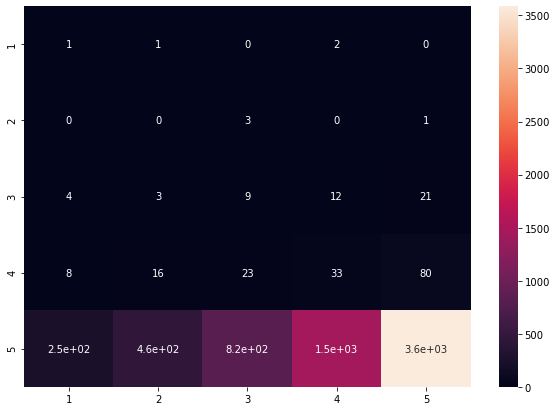

In [193]:
import seaborn as sn

val_loss, val_acc, val_rmse, predicciones = validation_metrics(model, valid_loader)
print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))

from sklearn.metrics import classification_report
# se muestran los resultados para comparar con los obtenidos
print(classification_report(y_test, predicciones, target_names=["1", "2", "3", "4", "5"]))

from sklearn.metrics import confusion_matrix
print("Confusion Matrix : ")
cm = confusion_matrix(predicciones, y_test)

print(cm)

df_cm = pd.DataFrame(cm, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

5. Genere y documente sus conclusiones (incluya al menos cuatro conclusiones importantes).

Importancia de meterle los pads, sin estos el modelo

Importancia de limpiar los textos, reducción en la cantidad de palabras únicas, 

LSTM appears to be theoretically involved, but its Pytorch implementation is pretty straightforward. Also, while looking at any problem, it is very important to choose the right metric, in our case if we’d gone for accuracy, the model seems to be doing a very bad job, but the RMSE shows that it is off by less than 1 rating point, which is comparable to human performance!

LSTM appears to be theoretically involved, but its Pytorch implementation is pretty straightforward. Also, while looking at any problem, it is very important to choose the right metric, in our case if we’d gone for accuracy, the model seems to be doing a very bad job, but the RMSE shows that it is off by less than 1 rating point, which is comparable to human performance!

Problema bastante dificil, incluso para los humanos

Pocas reviews de bajas estrellas (de baja puntuación), mientras que muchas de alta, lo que conlleva a que nuestro modelo se vea alterado y pueda identificar (trabajar) mejor las de 5
1 821
2 1549
3 2823
4 4908
5 12540

Referencias
----------------
*


https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df

## B. Reconocimiento   de   nombres   de   entidades   (NER,   Name   EntityRecognition) con redes neuronales recurrentes utilizando Pytorch.

El reconocimiento de nombres de entidades (NER)  es  el proceso  de identificar y categorizar elementos clave (ej. entidades) en el texto. Una entidad puede ser cualquier palabra o secuencia de palabras que se refieren a una persona, animal, sitio o cosa (ej.empresa, región geográfica, objeto). Cada entidad detectada se clasifica en una categoría predeterminada. Normalmente, NER se aborda como un problema de etiquetado de secuencias. Una explicación muy detallada de porqué es importante extraer entidades de los textos se encuentra en (Monge, 2020).

Los algoritmos de extracción de entidades pueden únicamente detectar la presencia de una entidad y marcarla como tal o pueden detectar y clasificar cada entidad que encuentran.

Ejemplo: En una oración como “arbusto de 2 m. flores lila.”.  Cada palabra representa un token donde “arbusto” y “flores” son los elementos de interés a marcar. El etiquetado “token inicial- token interno” es una forma común de indicar dónde comienzan y terminan las entidades. En el ejemplo anterior la etiqueta sería “B O O O B O” donde B representael inicio de la entidad y O cualquier otro token. Para la oración “botones florales rosados.” la etiqueta estaría dada por “B I O” donde “B” marca el token inicio de la entidad e “I” los otros tokens que son parte de esta, es decir “B I” delimita la entidad “botones florales”. 

Otra forma de marcar y etiquetar, es además de delimitar la entidad, asignar a esta la clase a la que corresponde, por ejemplo: empresa, ciudad, persona, entre otros. Para el presente ejercicio se va a utilizar este enfoque.

Utilice los datos para reconocer y clasificar nombres de entidades compartidos en Kaggle por (Ranjan, 2020) para:

1. Cargue y prepare los datos para ser introducidos a la red recurrente.

In [227]:
nRowsRead = 1000

# Se carga el archivo con los datos solicitados (defaultofcredit.csv) y se define
# a la columna "default_payment_next_month" como la objetivo.
ner = pd.read_csv('./data/NER_Dataset.csv', delimiter=',', nrows=nRowsRead)

ner.describe()

,Sentence_ID,Word,POS,Tag
count,1000,1000,1000,1000
unique,1000,1000,997,877
top,Sentence: 10764,"['It', 'is', 'written', 'in', 'brown', 'and', ...","['NNP', 'POS', 'NNP', 'NNP', 'VBZ', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
freq,1,1,3,13


In [228]:
# Delete missing observations for following variables
# for x in ["Clothing ID","Age","Title","Review Text","Rating","Recommended IND","Positive Feedback Count","Division Name","Department Name","Class Name"]:
#     reviews = reviews[reviews[x].notnull()]
    
# X = reviews.drop(columns = reviews.columns[3:5])
# X = pd.get_dummies(X)
# y = reviews['Review Text']
# y = [elem.split() for elem in y]

#reviews['Rating'] = reviews[(reviews['Rating'] >= 1)  (reviews['Rating'] <= 5)]


# ner["Word"] = ner["Word"].str.replace(r"'", '', regex=True)
# ner["Word"] = ner["Word"].str.replace(r"[", '', regex=True)
# ner["Word"] = ner["Word"].str.replace(r"]", '', regex=True)
# ner["Word"] = ner["Word"].str.replace(r" ", '', regex=True)

# ner["Word"] = ner["Word"].str.replace(r"'", '', regex=True)
# ner["Word"] = ner["Word"].str.replace(r"[", '', regex=True)
# ner["Word"] = ner["Word"].str.replace(r"]", '', regex=True)
# ner["Word"] = ner["Word"].str.replace(r" ", '', regex=True)

#ner["Word"] = ner["Word"].Series.str.replace('[', '', regex=True)

for x in ["Word", "Tag"]:
#     ner[x] = ner[x].str.replace("[", '', 1, regex=True)
#     ner[x] = ner[x][-1].str.replace("]", '', 1, regex=True)
    ner[x] = ner[x].str.replace("'", '', regex=True)
    ner[x] = ner[x].str.replace(", ", ' ', regex=True)

In [229]:
X = ner['Word']
X = [elem[1:-1].split() for elem in X]
# X[0] = X[0][1:]
# X[-1] = X[0][1:]
y = ner['Tag']
y = [elem[1:-1].split() for elem in y]
# y.pop(0)
# y.pop()


# def limpiar_datos(dataset):
#     for i in range(len(dataset)):
#         dataset[i].remove()
    
word_to_ix = {}
for frase in X:
#     if review not in word_to_ix:
#         word_to_ix[review] = len(word_to_ix)
    for palabra in frase:
        if palabra not in word_to_ix:
            word_to_ix[palabra] = len(word_to_ix)

            
etiquetas_a_indice = {'O':0,'B-geo':1,'B-gpe':2,'B-org':3,'B-nat':4,'B-art':5,'B-eve':6,'B-tim':7,'B-per':8,
                      'I-geo':9,'I-gpe':10,'I-org':11,'I-nat':12,'I-art':13,'I-eve':14,'I-tim':15,'I-per':16}

In [230]:
flatten = lambda t: [item for sublist in t for item in sublist]
test = flatten(y)
# print(test)
myset = set(test)
print(myset)
len(word_to_ix)

{'B-org', 'I-eve', 'B-gpe', 'I-geo', 'I-gpe', 'B-tim', 'B-art', 'I-org', 'O', 'I-tim', 'B-eve', 'B-per', 'B-nat', 'I-art', 'B-geo', 'I-per', 'I-nat'}


4783

2. Utilizando PyTorch defina una red recurrente LSTM para procesar, localizar y clasificar las entidades presentes en el texto (como la vista en clase). 

In [231]:
# Definición del modelo

# El modelo es una clase que debe heredar de nn.Module
class LSTMTagger(nn.Module):
    
    # Incialización del modelo
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
 

        # Primero se pasa la entrada a través de una capa Embedding. 
        # Esta capa construye una representación de los tokens de 
        # un texto donde las palabras que tienen el mismo significado 
        # tienen una representación similar.
        
        # Esta capa captura mejor el contexto y son espacialmente 
        # más eficientes que las representaciones vectoriales (one-hot vector).
        # En Pytorch, se usa el módulo nn.Embedding para crear esta capa, 
        # que toma el tamaño del vocabulario y la longitud deseada del vector 
        # de palabras como entrada. 
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # El LSTM toma word_embeddings como entrada y genera estados ocultos
        # con dimensionalidad hidden_dim.  
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # La capa lineal mapea el espacio de estado oculto 
        # al espacio de etiquetas
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        # Pase hacia adelante de la red. 
        # Parámetros:
        #    sentence: la oración a procesar
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))

#         print('tag_space', tag_space)
        
        # Se utiliza softmax para devolver un peso por etiqueta
        tag_scores = F.log_softmax(tag_space, dim=1)
#         print('tag_scores', tag_scores)
        return tag_scores

# Instanciación del modelo, definición de la función de pérdida y del optimizador   

# Hiperparámetros de la red
# Valores generalmente altos (32 o 64 dimensiones).
# Se definen pequeños, para ver cómo cambian los pesos durante el entrenamiento.

EMBEDDING_DIM = 6#34
HIDDEN_DIM = 6#34

# Instancia del modelo
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(etiquetas_a_indice)) # len([1,2,3,4,5]))

# Función de pérdida: Negative Log Likelihood Loss (NLLL). 
# Útil para problemas de clasificacion con C clases.
loss_function = nn.NLLLoss()#nn.CrossEntropyLoss()#nn.NLLLoss()

# Optimizador Stochastic Gradient Descent  
optimizer = optim.SGD(model.parameters(), lr=0.1)

3. Separe las muestras en datos de entrenamiento y evaluación y entrene el modelo. 

In [232]:
proporcion = lambda : 0.7

# Se randomizan las posiciones de las clases.
random.shuffle(X, proporcion)
random.shuffle(y, proporcion)

indice = int(len(X)*0.3)

X_train, y_train = X[indice:], y[indice:]
X_test, y_test = X[:indice], y[:indice]

print('X_train', X_train[2], len(X_train), len(X_train[0]))
print('y_train', y_train[2], len(y_train), len(y_train[0]))

X_train ['The', 'group', 'says', 'its', 'departure', 'will', 'affect', '3,00,000', 'people', 'in', 'South', 'Darfur', '.'] 700 19
y_train ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'O'] 700 19


In [233]:
# Preparación de los datos 
def prepare_sequence(seq, to_ix):
    # Prepara tensores de indices de palabras a partir de una oración.
    # Parámetros:
    #   seq: oración
    #   to_ix: diccionario de palabras.
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# Entrenar el modelo 

# Valores antes de entrenar
# El elemento i, j de la salida es la puntuación entre la etiqueta j para la palabra i.
with torch.no_grad():
    inputs = prepare_sequence(X_train[0], word_to_ix)
    
#     print('inputs', inputs, inputs.size())
    
    tag_scores = model(inputs)
    
#     print(X_train[0])
    
    # Clasificación    
#     print(tag_scores)

# Corridas o épocas
for epoch in range(100):  
    
    if epoch % 10 == 0:
        print(epoch)
    
    for sentence, etiqueta in zip(X_train, y_train):
#         print('sentence', sentence)
#         print('tags', etiqueta)
        ## Paso 1. Pytorch acumula los gradientes.
        # Es necesario limpiarlos
        model.zero_grad()

        # Paso 2. Se preparan las entradas, es decir, se convierten a
        # tensores de índices de palabras.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(etiqueta, etiquetas_a_indice)
#         print('targets', targets)
        
        # Paso 3. Se genera la predicción (forward pass).
        tag_scores = model(sentence_in)
#         print('tag_scores', tag_scores)

        # Paso 4. se calcula la pérdida, los gradientes, y se actualizan los 
        # parámetros por medio del optimizador.
#         print('tag_scores', tag_scores, tag_scores.size())
#         print('targets', targets)
        loss = loss_function(tag_scores, targets)
#         print('lossmljsmaLKMSALKmaslkMLKSAMlkmaldksmlkads\nlksadmldksamlkdsmlakds', loss)
        loss.backward()
        optimizer.step()

0
10
20
30
40
50
60
70
80
90


In [234]:
# Despligue de la puntuación luego del entrenamiento ## Se puede echar?
with torch.no_grad():
    inputs = prepare_sequence(X_train[0], word_to_ix)
    tag_scores = model(inputs)
   
    print("Resultados luego del entrenamiento para la primera frase")
    # Las palabras en una oración se pueden etiquetar de tres formas.
    # La primera oración tiene 4 palabras "El perro come manzana"
    # por eso el tensor de salida tiene 4 elementos. 
    # Cada elemento es un vector de pesos que indica cuál etiqueta tiene más
    # posibilidad de estar asociada a la palabra. Es decir hay que calcular 
    # la posición del valor máximo
    print(tag_scores)

Resultados luego del entrenamiento para la primera frase
tensor([[-6.5440e-03, -8.4883e+00, -9.4271e+00, -5.8733e+00, -9.0198e+00,
         -8.9164e+00, -1.0297e+01, -8.8808e+00, -6.5064e+00, -1.1495e+01,
         -1.0145e+01, -9.5823e+00, -1.0027e+01, -1.0672e+01, -1.0074e+01,
         -9.8730e+00, -6.7078e+00],
        [-2.7418e-05, -1.6027e+01, -1.5215e+01, -1.1259e+01, -1.4111e+01,
         -1.3752e+01, -1.6468e+01, -1.1862e+01, -1.3712e+01, -1.4868e+01,
         -1.6624e+01, -1.4648e+01, -1.5587e+01, -1.6179e+01, -1.7498e+01,
         -1.2817e+01, -1.5813e+01],
        [-2.9053e+00, -1.5297e+00, -2.0516e+00, -8.3235e-01, -5.8421e+00,
         -4.4684e+00, -6.7194e+00, -3.5765e+00, -2.2183e+00, -6.7299e+00,
         -6.7551e+00, -5.2448e+00, -7.2497e+00, -7.8540e+00, -7.6201e+00,
         -6.5781e+00, -6.1395e+00],
        [-4.1559e+00, -8.4773e+00, -4.3253e+00, -5.3373e+00, -6.1096e+00,
         -7.0858e+00, -7.4938e+00, -5.2391e+00, -3.0184e+00, -3.6730e+00,
         -6.0236e+00,

In [243]:
# Probar el modelo

def test_examples(test_data):

   with torch.no_grad():
      inputs = prepare_sequence(test_data, word_to_ix)
      tag_scores = model(inputs)
    
 
#    print("FRASE") 
#    print("La frase original", test_data)    
#    print("La frase original preprocesada", inputs)
#    print("Salida del modelo", tag_scores)
#    print("Valores máximos e índices", max_values(tag_scores))
   return max_values(tag_scores)
    

#print("Índice de palabras")
#print("word_to_idx", word_to_ix)

print("Etiquetas")
print(etiquetas_a_indice)

#Frase 1
# Las palabras en una oración se pueden etiquetar de tres formas.
# La primera oración tiene 3 palabras "El perro juega"
# por eso el tensor de salida tiene 3 elementos. 
# Cada elemento es un vector de pesos que indica cuál etiqueta tiene más
# posibilidad de estar asociada a la palabra. Es decir hay que calcular 
# la posición del valor máximo. 
#   Ejemplo 1: "El perro juega" ["DET", "NN", "V"]
# Ejemplo: 0, 1, 2 {"DET": 0, "NN": 1, "V": 2} => DET, NN, V 
test_examples(X_test[0])
print('y_test', y_test[0])

[0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']

Etiquetas
{'O': 0, 'B-geo': 1, 'B-gpe': 2, 'B-org': 3, 'B-nat': 4, 'B-art': 5, 'B-eve': 6, 'B-tim': 7, 'B-per': 8, 'I-geo': 9, 'I-gpe': 10, 'I-org': 11, 'I-nat': 12, 'I-art': 13, 'I-eve': 14, 'I-tim': 15, 'I-per': 16}
y_test ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-gpe',
 'O',
 'O',
 'O',
 'O',
 'O']

4. Evalúe el modelo resultante. Utilice la métrica propuesta por el InternationalWorkshop on Semantic Evaluation (SemEval), una explicación básica está disponible en (Batista, 2018).  

In [247]:
# #evaluator = Evaluator(true, pred, tags=['LOC', 'PER'])

# # y_pred = model(X_test)
# # labels = list(model.classes_)
# # labels.remove('O') # remove 'O' label from evaluation
# # sorted_labels = sorted(labels,key=lambda name: (name[1:], name[0])) # group B and I results
# # print(sklearn_crfsuite.metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

# import sklearn_crfsuite
# from sklearn_crfsuite import metrics

# def max_values(x):
#     # Retorna el valor máximo y en índice o la posición del valor en un vector x.
#     # Parámetros: 
#     #    x: vector con los datos. 
#     # Salida: 
#     #    out: valor 
#     #    inds: índice
#     out, inds = torch.max(x,dim=1)   
#     return out, inds

# y_pred = []

# # print('X_test', X_test)

# # for i in range(len(X_test)):
    
# #     with torch.no_grad():
        
# #         input = prepare_sequence(X_test[i], word_to_ix)
        
# #         tag_scores = model(inputs)
# #         print(tag_scores)
# # #         print(tag_scores)

# #     _, tag_pred = max_values(tag_scores)
# # #     print('tag_pred', tag_pred)
# # #         print(tag_pred)
# #     y_pred.append(tag_pred)
    

# for elem in X_test:
    
# #     with torch.no_grad():
        
# #         input = prepare_sequence(elem, word_to_ix)
        
# #         tag_scores = model(inputs)
# #         print(tag_scores)
# # #         print(tag_scores)

# #     _, tag_pred = max_values(tag_scores)
# #     print('tag_pred', tag_pred)
# #         print(tag_pred)
#     _, tag_pred = test_examples(elem)
#     print(tag_pred)
#     y_pred.append(tag_pred)
        
# sorted_labels = [k for k, v in etiquetas_a_indice.items()]
# print('sorted_labels', sorted_labels, len(sorted_labels))
# # print('y_test', y_test[0], len(y_test[0]))
# # print('y_pred', y_pred[0], len(y_pred[0]))

# # [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]
# # ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']

# [-4.7684e-07, -2.0116e+01, -2.0555e+01, -1.4824e+01, -1.8221e+01,
#          -1.6978e+01, -1.9745e+01, -1.6455e+01, -1.8519e+01, -1.7782e+01,
#          -1.9167e+01, -1.7576e+01, -1.9413e+01, -2.0180e+01, -2.0123e+01,
#          -1.6126e+01, -1.8655e+01]

# print(sklearn_crfsuite.metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
tensor([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 9, 0, 0, 0, 0, 0, 0, 3, 0,
        0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 8,
        0, 0, 0, 0, 0, 0])
tensor([ 0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7, 11, 11,  0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([8, 0, 0, 0, 0, 0, 1, 0, 1, 0, 3, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([ 8, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  1,  0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 7, 0])
tensor([0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        7, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0])
tensor([1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([8, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 7, 0])
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, 11,  0,  0,  0,
         0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,
         0])
tensor([0, 0, 0, 0, 0, 0, 0, 3, 0, 8, 0, 0, 3, 0, 0, 0, 0, 0, 0])
tensor([ 8, 16,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 11,  0])
tensor([0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0

/home/walter/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-geo', 'B-gpe', 'B-org', 'B-nat', 'B-art', 'B-eve', 'B-tim', 'B-per', 'I-geo', 'I-gpe', 'I-org', 'I-nat', 'I-art', 'I-eve', 'I-tim', 'I-per'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


ValueError: Mix of label input types (string and number)

In [249]:
from copy import deepcopy 

# Probar el modelo

# Funciones utilitarias

def max_values(x):
    # Retorna el valor máximo y en índice o la posición del valor en un vector x.
    # Parámetros: 
    #    x: vector con los datos. 
    # Salida: 
    #    out: valor 
    #    inds: índice
    out, inds = torch.max(x,dim=1)   
    return out, inds

def test_examples(test_data):

   with torch.no_grad():
      inputs = prepare_sequence(test_data, word_to_ix)
      tag_scores = model(inputs)
        
      _, pred = max_values(tag_scores)
    
#    print("Salida del modelo", tag_scores)
#    print("Valores máximos e índices", max_values(tag_scores))    
    
   return pred.tolist()
#    print("La frase original", test_data)    
#    print("La frase original preprocesada", inputs)
    

#print("Índice de palabras")
#print("word_to_idx", word_to_ix)

print("Etiquetas")
# print(etiquetas_a_indice)

#Frase 1
# Las palabras en una oración se pueden etiquetar de tres formas.
# La primera oración tiene 3 palabras "El perro juega"
# por eso el tensor de salida tiene 3 elementos. 
# Cada elemento es un vector de pesos que indica cuál etiqueta tiene más
# posibilidad de estar asociada a la palabra. Es decir hay que calcular 
# la posición del valor máximo. 
#   Ejemplo 1: "El perro juega" ["DET", "NN", "V"]
# Ejemplo: 0, 1, 2 {"DET": 0, "NN": 1, "V": 2} => DET, NN, V 
y_pred = []
y_test_procesed = []

print(y_test[0])

for i in range(len(X_test)):
    y_pred.append(test_examples(X_test[i]))
    y_test_procesed.append(prepare_sequence(y_test[i], etiquetas_a_indice).tolist())
    
# print(y_test[0])
# print('-------')
# test_examples(X_test[1])
# print(y_test[1])
# print('-------')
# test_examples(X_test[2])
# print(y_test[2])
# print('-------')
# test_examples(X_test[3])
# print(y_test[3])
# print('-------')
# test_examples(X_test[4])
# print(y_test[4])

# [-3.1003e+00, -9.2929e+00, -3.9115e-01, -3.6556e+00, -7.8349e+00,
#          -6.5042e+00, -8.1129e+00, -1.1431e+01, -1.5858e+00, -5.1965e+00,
#          -7.3174e+00, -6.6276e+00, -7.0125e+00, -7.3155e+00, -7.7962e+00,
#          -8.8214e+00, -3.3208e+00]

# [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]

sorted_labels = [k for k, v in etiquetas_a_indice.items()]
print(sorted_labels, 'sorted_labels')
labels_procesed = deepcopy(sorted_labels[1:])
print(labels_procesed, 'labels_procesed')

pred_labels = []

for i in range(len(y_pred)):
    temp = []
    for elem in y_pred[i]:
        temp.append(sorted_labels[elem])
    pred_labels.append(temp[:])

# for elem in y_pred[index]:
#     pred_labels.append(sorted_labels[elem])
# print('sorted_labels', sorted_labels, len(sorted_labels))
# print('---------------')

for i in range(len(y_test)):
    if len(y_test[i]) != len(pred_labels[i]):
        print('_________________________________', i)
        print('y_test[i]', y_test[i], len(y_test[i]))
        print('pred_labels[i]', pred_labels[i], len(pred_labels[i]))

print('y_test', y_test[:3], len(y_test))

print('---------------')
print('pred_labels', pred_labels[:3], len(pred_labels))

print(sklearn_crfsuite.metrics.flat_classification_report(y_test, pred_labels, labels=labels_procesed, digits=3))

Etiquetas
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
['O', 'B-geo', 'B-gpe', 'B-org', 'B-nat', 'B-art', 'B-eve', 'B-tim', 'B-per', 'I-geo', 'I-gpe', 'I-org', 'I-nat', 'I-art', 'I-eve', 'I-tim', 'I-per'] sorted_labels
['B-geo', 'B-gpe', 'B-org', 'B-nat', 'B-art', 'B-eve', 'B-tim', 'B-per', 'I-geo', 'I-gpe', 'I-org', 'I-nat', 'I-art', 'I-eve', 'I-tim', 'I-per'] labels_procesed
y_test [['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O'], ['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O']] 300
---------------
pred_labels [['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O'

/home/walter/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-geo', 'B-gpe', 'B-org', 'B-nat', 'B-art', 'B-eve', 'B-tim', 'B-per', 'I-geo', 'I-gpe', 'I-org', 'I-nat', 'I-art', 'I-eve', 'I-tim', 'I-per'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/walter/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/walter/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to cont

In [ ]:
index = 0
true = collect_named_entities(y_test[index])

    
# print(pred_labels)
    
pred = collect_named_entities(pred_labels[index])

true

In [ ]:
pred

In [ ]:
compute_metrics(true, pred, ['geo', 'gpe'])

In [ ]:
metrics_results = {'correct': 0, 'incorrect': 0, 'partial': 0,
                   'missed': 0, 'spurious': 0, 'possible': 0, 'actual': 0, 'precision': 0, 'recall': 0}

# overall results
results = {'strict': deepcopy(metrics_results),
           'ent_type': deepcopy(metrics_results),
           'partial':deepcopy(metrics_results),
           'exact':deepcopy(metrics_results)
          }

labels_test = ['nat', 'geo', 'tim', 'eve', 'per', 'org', 'art', 'gpe']

# results aggregated by entity type
evaluation_agg_entities_type = {e: deepcopy(results) for e in labels_test}

for true_ents, pred_ents in zip(y_test, pred_labels):
#     print(true_ents)
#     print(pred_ents)
    
    # compute results for one message
    tmp_results, tmp_agg_results = compute_metrics(
        collect_named_entities(true_ents), collect_named_entities(pred_ents),  labels_test
    )
    
    #print(tmp_results)

    # aggregate overall results
    for eval_schema in results.keys():
        for metric in metrics_results.keys():
            results[eval_schema][metric] += tmp_results[eval_schema][metric]
            
    # Calculate global precision and recall
        
#     print('results', results)
        
    results = compute_precision_recall_wrapper(results)

#     print('results', results)

    # aggregate results by entity type
 
    for e_type in labels_test:

        for eval_schema in tmp_agg_results[e_type]:
#             print(eval_schema)

            for metric in tmp_agg_results[e_type][eval_schema]:
#                 print(metric)
                if metric == 'f1': # if el resultado va a ser 0 continue
                    continue
                evaluation_agg_entities_type[e_type][eval_schema][metric] += tmp_agg_results[e_type][eval_schema][metric]
                
        # Calculate precision recall at the individual entity level
                
        evaluation_agg_entities_type[e_type] = compute_precision_recall_wrapper(evaluation_agg_entities_type[e_type])


In [ ]:
results

In [ ]:
evaluation_agg_entities_type

In [ ]:
evaluator = Evaluator(y_test, pred_labels, labels_test)
results, results_agg = evaluator.evaluate()

In [ ]:
results

In [ ]:
results_agg

In [ ]:
# import seaborn as sn

# from sklearn.metrics import confusion_matrix
# print("Confusion Matrix : ")
# cm = confusion_matrix(pred_labels, y_test)

# print(cm)

# df_cm = pd.DataFrame(cm, index = [i for i in "12345"],
#                   columns = [i for i in "12345"])
# plt.figure(figsize = (10,7))
# sn.heatmap(df_cm, annot=True)

5. Genere   y   documente   sus   conclusiones   (incluya   al   menos   cuatro conclusiones importantes).

Importancia de limpiar los textos, si no se hubieran eliminado las comillas, signos de puntuación, los textos no servirían

Importancia de nuestro modelo en el procesamiento del lenguaje. Es importante para las máquinas comprender nuestra semántica para entendernos a nosotros.

Un trabajo que manualmente sería complicadísimo, nuestro modelo es capaz de realizarlo con una precisión aceptable.

http://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/

Referencias
----------------
*